In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
import utils_function
import utils_class

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict
from os.path import splitext
from contextlib import contextmanager
from pathlib import Path
import networkx as nx
from decorator import decorator
from networkx.utils import create_random_state, create_py_random_state

In [ ]:
filename = "/content/drive/MyDrive/ADM/HW5/"
#filename = "/content/drive/MyDrive/HW5/"

# Homework 5 - Exploring StackOverflow! - Group #19

1. Mantuano Andrea 1739874
2. Makar Mina 1804475
3. Iovino Giuliana 2017512


## 1. Data

**a2q** contains informations about **Answers to questions** - User u answered user v's question at time t

**c2a** contains informations about **Comments to questions** - User u commented on user v's question at time t

**c2q** contains informations about **Comments to answers** - User u commented on user v's answer at time t

In [ ]:
a2q = pd.read_csv(filename + 'sx-stackoverflow-a2q.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)
c2a = pd.read_csv(filename + 'sx-stackoverflow-c2a.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)
c2q = pd.read_csv(filename + 'sx-stackoverflow-c2q.txt.gz', compression='gzip', header=None, sep=' ', quotechar='"', error_bad_lines=False)

we trasform timestamp in date.

In [ ]:
a2q[2] = pd.to_datetime(a2q[2], unit='s').dt.strftime("%Y%m%d").astype(int)
c2a[2] = pd.to_datetime(c2a[2], unit='s').dt.strftime("%Y%m%d").astype(int)
c2q[2] = pd.to_datetime(c2q[2], unit='s').dt.strftime("%Y%m%d").astype(int)

In order to have not loops in the graph, and to have not problems walking along the paths, we preferred to drop the nodes that are linked themselves.

In [ ]:
c2q.drop(c2q[c2q[0] == c2q[1]].index, inplace = True)
c2a.drop(c2a[c2a[0] == c2a[1]].index, inplace = True)
a2q.drop(a2q[a2q[0] == a2q[1]].index, inplace = True)

In order to get an immediate answer we preferred to take a small subset of data over a period of time, in this case all data recorded before 2009.

In [ ]:
subset_a2q = a2q[a2q[2] < 20090101].copy()
subset_c2a = c2a[c2a[2] < 20090101].copy()
subset_c2q = c2q[c2q[2] < 20090101].copy()

In [ ]:
users = dict()
users = create_graph(subset_a2q, "a2q", 1, users)
users = create_graph(subset_c2a, "c2a", 2, users)
users = create_graph(subset_c2q, "c2q", 3, users)

In [ ]:
import pickle
with open(filename + 'graph.pickle', 'wb') as fp:
    pickle.dump(users, fp, pickle.HIGHEST_PROTOCOL)

### LOAD DATA FROM FILE

In [ ]:
import pickle
filename = '/content/drive/MyDrive/ADM/HW5/graph.pickle'
with open(filename, 'rb') as handle:
    graph = pickle.load(handle)

## 2. Implementation of the backend

In [ ]:
def call_function(name_graph, i):
    if i == 1:
        return get_features(name_graph)

### Functionality 1 - Get the overall features of the graph

In [ ]:
call_function("a2q", 1)

### Functionality 2 - Find the best users!

The **PageRank Centrality** of a node **u** is defined as: 

$$PR(p_{i}) = \frac{1-d}{N} + d{\sum_{p_{j} \in M(p_i)}{\frac{PR(p_{j})}{L(pj)}}}$$

where **d** is the damping factor, $M(p_i)$ is the set of neighbors of the node $p_{i}$, $L(p_{j})$  is the number of outbound edges of the node $p_{j}$ and **N** is the total number of nodes.

In [ ]:
def page_rank(graph, source, start, end):
    start, end = convertDate(start), convertDate(end)
    iterations, d = 100, 0.85
    n = len(graph)
    get_in_degree_user = {user: getDegree(graph[user].get_in_relation, start, end, False)[1] for user in graph}
    get_out_degree_user = {user: getDegree(graph[user].get_out_relation, start, end)[0] for user in graph}
    page_rank = {node: 1/n for node in graph}
    for iteration in range(iterations):
        for user in graph:
            sum = 0
            in_A = get_in_degree_user[user]
            for node in in_A:
                sum += page_rank[node] / get_out_degree_user[node]
            page_rank[user] = (0.15) / n +  d*sum
    return  page_rank

The **Degree Centrality** of a node **u** counts how many neighbors a node has. The graph that we are considering is directed and weighted, so we have to calculate two measures: **In-Degree Centrality** and **Out-Degree Centrality**. The **Out-Degree Centrality** for a weighted graph is defined as: 

$$C_{outD}(u) = \frac{\sum_{v=1}^{n} w_{uv}}{N-1}$$

where **n** are the nodes that are the number of tail ends adjacent to the node **v**, $w_{uv}$ is the weight of the link between the node **u** and the node **v** and **N-1** is the max possible value of $C_{outD}(u)$.

In [ ]:
def degreeCentrality(graph, source, start, end):
    start = convertDate(start)
    end = convertDate(end)
    weight = 0
    g = graph[source].get_out_relation
    for year in g:
        for rel in g[year]:
            for edge in g[year][rel]:
                weight += edge.weight
    return weight/(len(graph)-1)

The **Closeness Centrality** of a node **u** is the reciprocal of the average shortest path distance to **u** over all **n-1** nodes.

$$C(u) = \frac{n-1}{\sum_{v = 1}^{n-1}{d(v,u)}}$$

where **n-1** is the number of reachable nodes from **u** and **d(v,u)** is the shortest path distance between the node **u** and the node **v**. 


In [ ]:
def GetCloseness(graph, source, start, end):
    distances = 0
    keys = set(graph.keys())
    keys.remove((source))
    _, cost = myDijkstra(graph, source, start,end)
    cost = np.array(list(cost.values()))
    position = np.where(cost != float('inf'))[0]
    if sum(cost[position]) == 0: return 0
    return round((len(position) - 1) / sum(cost[position]),3)

The **Betweenness Centrality**  of a node **u** is the sum of the fraction of all-pairs shortest paths that pass through **u**:

$$C_{B}(u) = \sum_{s,t \in U}{\frac{\sigma(s,t|v)}{\sigma(s,t)}} $$

where **U** is the set of nodes, $\sigma(s,t|u)$ is the number of shortest (s, t)-paths and $\sigma(s,t)$ is the number of those paths passing through some node **u** other than **s**, **t**.

In [ ]:
from tqdm import tqdm
def BetweennessCentrality(graph, source, start, end):
    st, stv, el = 0, 0, 0
    sum = 0
    for s, t in tqdm(graph.items()):
        if s != source:
            prev, dist, path = dijkstraNumShortesPath(graph, s, start, end)
            for t in graph:
                if  s != t and t != source:
                    if prev[t] != -1:
                        all_path = allShortPath(prev, t, s, [], all_path=[]) 
                        freq = freq_(all_path)
                        if freq == -1 :
                            freq_source = 0
                        else:
                            freq_source = freq.get(source, 0)
                        if t in path:
                            sum += (freq_source) / path.get(t, 0)
    return round(sum / ((len(graph) -2) * (len(graph) - 1)), 3)

In [ ]:
def functionalitytwo (graph, source, start, end, metric):
    if (metric == "DegreeCentrality"):
        print("The Degree Centrality of node", source, "is", degreeCentrality(graph, source, start, end))
    if (metric == "Betweenness"):
        print("The Betweenness Centrality of node", source, "is", BetweennessCentralityy(graph, source, start, end))
    if (metric == "Closeness"):
        print("The Closeness Centrality of node", source, "is", GetCloseness(graph, source, start, end)
    if (metric == "PageRank"):"
        print("The Page Rank Centrality of node", source, "is", pagerank (graph, source, start,end))

In [ ]:
GetCloseness(graph, 3, "08/2008", "01/2009")

### Functionality 3 - Shortest Ordered Route

In [ ]:
p_1,p_n = 1, 49
orderedRoute = [17]
start = "08/2008"
end = "12/2008"

with open('graph (1).pickle', 'rb') as handle:
    graph = pickle.load(handle)
    
bestPath, cost = shortestOrderedRoute(graph,start, end,orderedRoute,p_1,p_n)

print("The shortest ordered route between", p_1, "and", p_n,"is:",bestPath, "\nand it costs:", cost)

### Functionality 4 - Disconnecting graphs

In [ ]:
def minCut(graph, source, target, start=200808, end=201612):
    res = createResidualG(graph)
    max_flow = 0
    path = dict()

    while BFS(res, source, target, path, start, end)[0]:
        bottleneck = getBottleneck(path, source, target)
        max_flow += bottleneck
        updateResGraph(res, path, bottleneck, source, target)
    
    print("Max Flow is:", max_flow)
    reachable = reachFromS(res, source, start, end) 
    edges = set()
    capacity = 0
    for v in reachable:
        neighbor = graph[v].get_out_relation
        for year in neighbor:
            for rel in neighbor[year]:
                for i in range(len(neighbor[year][rel])):
                    relX = res[v].get_out_relation[year][rel][i]
                    rely = graph[v].get_out_relation[year][rel][i]

                    if (start <= relX.time <= end) and relX.weight == 0 and relX.target not in reachable and (v, relX.target) not in edges:
                        edges.add((v, relX.target))
                        capacity += rely.weight 
                
    print("Capacity is:", capacity)
    return edges

In [ ]:
print("The edges to cu if we want to disconnect", 83658, "and", 3225108, "are:", *minCut(merge_graph, 83658, 3225108))

## 3. Implementation of the frontend


In [ ]:
G = graph_to_networkx(graph, 'all')

### Visualization 1 - Visualize the overall features of the graph

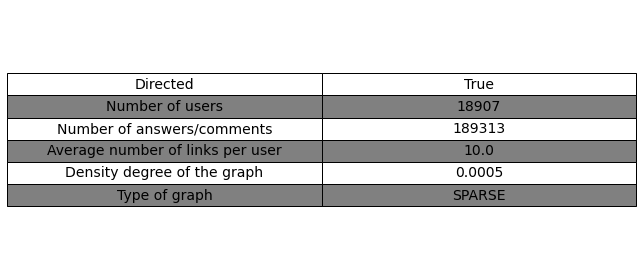

In [ ]:
call_function("a2q", 1)

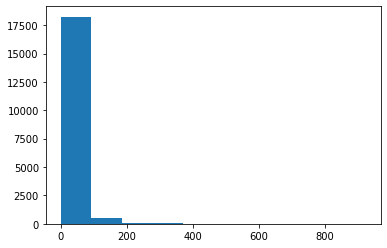

In [ ]:
degrees = [G.degree(n) for n in G.nodes()]
plt.hist(degrees)
plt.show()

### Visualization 2 - Visualize the best user!

In [ ]:
def plotgraph(graph, node, start, end):
    neigh = getNeighbors(node, graph, start, end)
    neighlist = list(neigh)
    nodes = neighlist + [node]
    graph = graph_to_networkx(graph, "all")
    sub = graph.subgraph(nodes)
    pos = nx.spring_layout(sub, k = 1, iterations = 20)  
    plt.figure(figsize=(25,10))
    labels = nx.draw_networkx_labels(sub, pos= pos, alpha = 1)
    nx.draw_networkx_nodes(sub, pos, node_size= 800, node_color='green', alpha = 0.7, label = labels)
    nx.draw_networkx_nodes(sub, pos, node_size= 1000, nodelist = [node], node_color='red', alpha = 0.7, label = labels)
    nx.draw_networkx_edges(sub, pos, width=0.8, alpha = 0.8, edge_color="dimgrey",  arrowsize=15, node_size = 1000)
    plt.title("Neighbors of node {}".format(node), fontsize = 20)
    plt.axis("off")
    plt.show()

In [ ]:
import datetime
def equi_intervals(start_date, end_date, N):
    # initializing dates
    test_date1 = datetime.datetime.strptime(start_date, '%m/%Y')
    test_date2 = datetime.datetime.strptime(end_date, '%m/%Y')

    N = N
    temp = []

    # getting diff.
    diff = ( test_date2 - test_date1) // N
    for idx in range(0, N):

        # computing new dates
        temp.append((test_date1 + idx * diff))

    res = []
    for sub in temp:
        res.append(sub.strftime('%m/%Y'))

    # printing result
    return res + [end_date]

In [ ]:
def plotmetric(graph, node, start, end, metrica, n):
    intervals = equi_intervals(start, end, n)
    metric = list()
    for i in range(n):
    metric.append(metrics(graph, node, intervals[i], intervals[i+1], metrica))
    interv = [f"{[intervals[i],intervals[i+1]]}" for i in range(n)]
    plt.bar(interv, metric)
    plt.xticks(rotation=90)
    plt.show()

## VIEWS 3.3

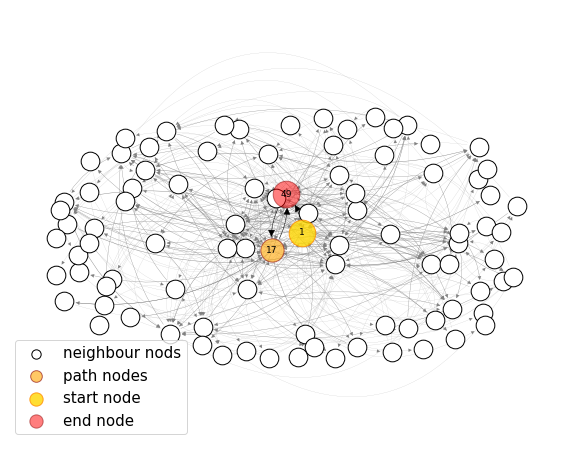

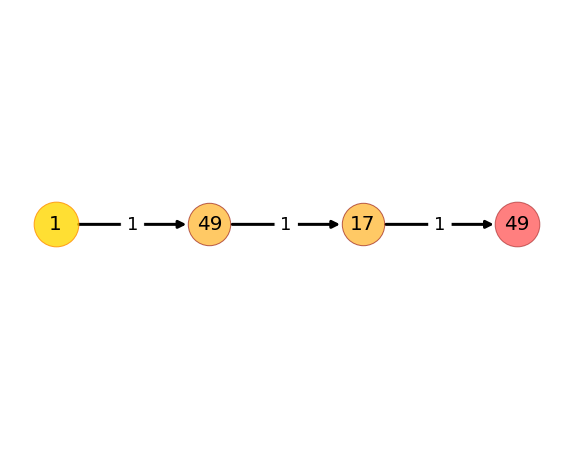

In [132]:
visualization3(graph,[1, 49, 17, 49], 200808, 200812, k = 0.8 ,seed = 125)

## VIEWS 3.4

In [ ]:
result = dict()
g1 = graph_by_interval(graph2, "01/2016", "01/2016")
g2 = graph_by_interval(graph2, "02/2016", "02/2016")

In [ ]:
merge_graph = merge(g1, g2)

In [ ]:
plotgraph(graph, 1, "08/2008", "08/2008")

Firstly we try the algoritm in small graph, to see if the algorithm behaves correctly. As we can see the algorithm remove 3 edges $[(1,3), (2,5), (4,5)]$, and the sum of weights of those edges is $13$ that is the minimum weight, infact if we had remove the first 2 edges in graph $[(0,2), (0,1)]$ the sum of weights is $17$ and the second one is bigger than the first, so is correct to remove this 3 edges.

Max Flow is: 13
Capacity is: 13


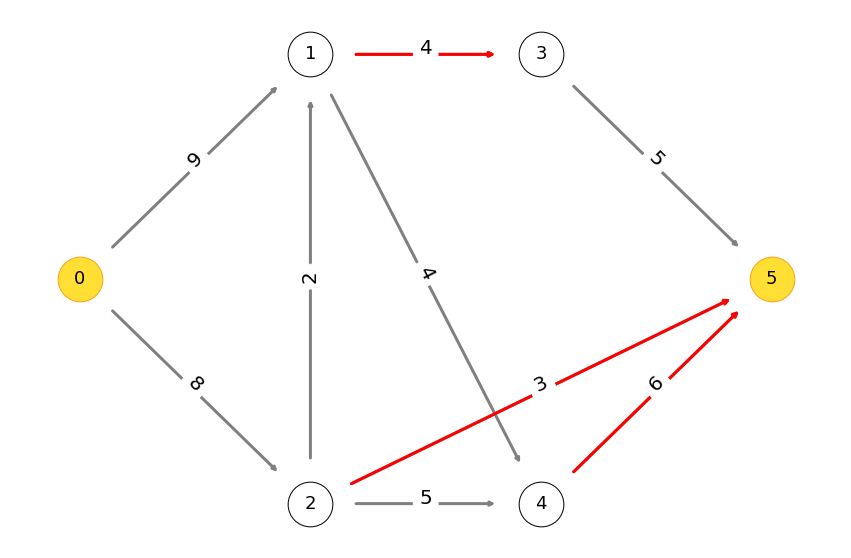

In [143]:
visualization4(users, 0, 5, 1, 12, minCut(users, 0, 5, start=197001, end=197001))

Then we decided to test our algorithm on the graph we worked on. In order to get a tidier picture we chose to display only the nodes reachable from the source and not the graph in its entirety. 

We can see in this picture that we want to disconnect the two golden nodes wich are :  $184, 1944$. To do this we run our max flow - min cut algorithm that tells us that if we want to disconnect the two previous nodes, we need to remove only 2 edges that are represented in red, they are: $(184, 1944), (770, 4262)$.

In [144]:
minCut(graph4, 184, 1944)

Max Flow is: 2
Capacity is: 2


{(184, 1944), (770, 4262)}

Max Flow is: 2
Capacity is: 2


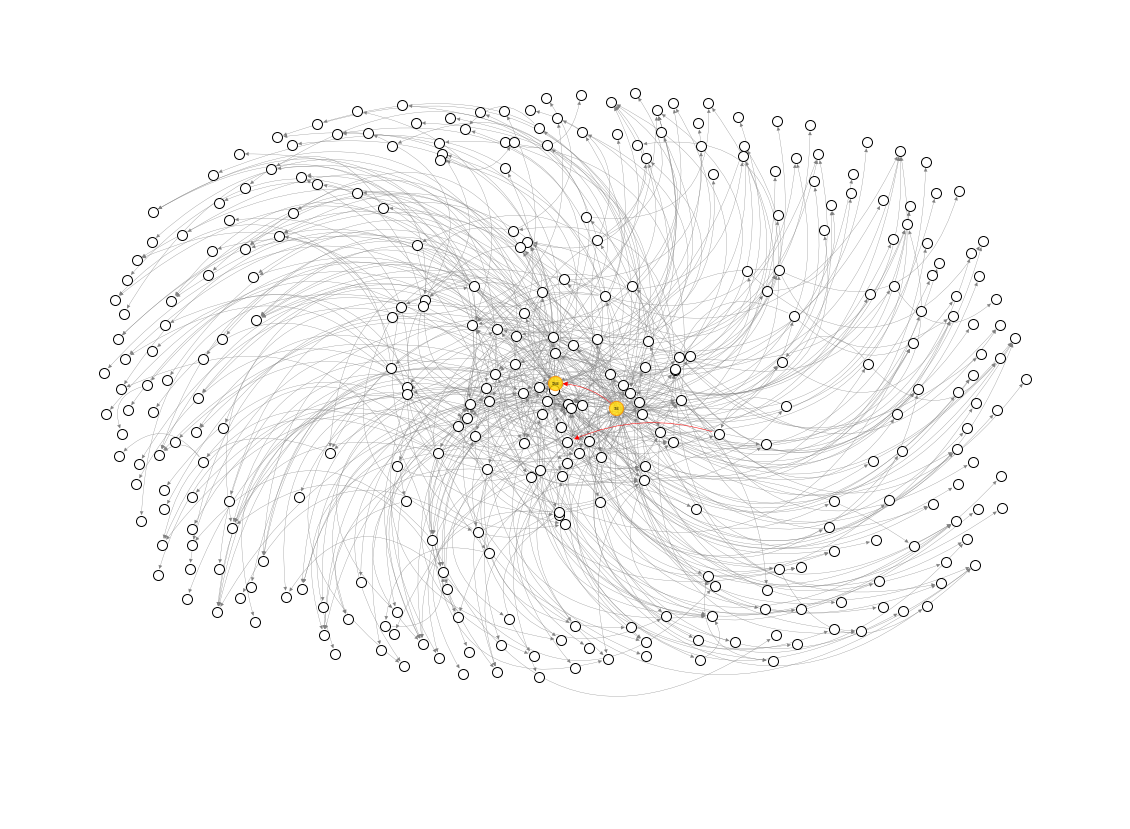

In [40]:
visualization4(graph_user, 184, 1944, 0.1, 5, minCut(graph4, 184, 1944))

# 4. Algorithmic question

We need to create an algorithm that given as input a list of k pairs of n kids that may argue, it try to split them in two dormitories.

To test if it was possible to divide the children into two dormitories, we create an auxilary function **assign_dormitory_to_child** which,given as input:
- the current *child*,
- the set of *dormitory_1* and *dormitory_2*, 
- the child with whom he might argue *not_with* 
- the set of the remaining *children*
it outputs whether is possible to *assign* the current *child*, the update of *dormitory_1* and *dormitory_2* and the set of the remaining *children*.

**assign_dormitory_to_child** checks if *child* is already in one of the two dormitories, if not, checks if in *dormitory_1* there is already the child with whom he would figth with (*not_with*), in the positive case add *child* to *dormitory_2*, otherwise try to insert him in *dormitory_1*.

In [ ]:
def assign_dormitory_to_child(child, dormitory_1, dormitory_2, not_with, children):
    assign = False
    if child not in dormitory_1 and child not in dormitory_2: #if no dormitory has been assigned to child 
        if not_with in dormitory_1: # if child_2 in dormitory_1, so we put child_1 in dormitory_2
            dormitory_2.add(child)
        else:
            dormitory_1.add(child)
        assign = True
        # updtating the set with the remaining kids
        children.remove(child)
    return assign, dormitory_1, dormitory_2, children

The function **create_pair** receives in input the number of kids *n* and the list of pairs of kids arguing *list_pair*, then we try to create the dormitories by scrolling the list. In case we find two children who cannot stay in the same dormitory we return the state of impossibility in creating the dormitories. 

If we can get all the kids who can fight to the right dormitory, we divide the rest of the children equally between the two dorms.

In [ ]:
def create_pair(n, list_pair):
    children = {i for i in range(n)} #set of children to be assigned a dormitory 
    dormitory_1 = set()
    dormitory_2 = set()
    for child_1, child_2 in list_pair:
        # check if (child_1, child_2) it's repeating and the two kids have already been placed in the right dorm 
        if (child_1 in dormitory_1 and child_2 in dormitory_2) or (child_1 in dormitory_2 and child_2 in dormitory_1):
            continue
        else:
            # try to assign dormitory to child_1
            assign_dormitory_child_1, dormitory_1, dormitory_2, children = assign_dormitory_to_child(child_1, dormitory_1, dormitory_2, child_2, children)
            # try to assign dormitory to child_2
            assign_dormitory_child_2, dormitory_1, dormitory_2, children = assign_dormitory_to_child(child_2, dormitory_1, dormitory_2, child_1, children)
            # if both have not been assigned a dormitory 
            if not assign_dormitory_child_1 and not assign_dormitory_child_2: 
                return "It's not possibile to divide the kids in two dormitories."
    # dividing the remaining kids equally
    for i, child in enumerate(children):
        if i % 2 == 0:
            dormitory_1.add(child)
        else:
            dormitory_2.add(child)     
    print("The kid in the first dormitory are:", dormitory_1,"\nThe kid in the second dormitory are:", dormitory_2 )

Lastly we decided to create a random list containing the k pairs, in order to test our algorithm.

In [ ]:
# generate random integer values
from random import seed
from random import randint

def dislikes(k,n):
    dislike = []
    # seed random number generator
    seed(124)
    for _ in range(k):
        # generate some integers
        x = randint(0, n)
        y = randint(0, n)
        
        while x == y:
            y = randint(0, n)
            
        dislike.append((x,y))
    return dislike

In [ ]:
n,k = 21 ,7
l = dislikes(k,n)
print(l)
create_pair(n,l)

In [ ]:
l = [(0,1), (1,2),(1,3),(1,4),(1,5),(1,6)]
create_pair(7,l)

In [ ]:
l = [(1,2),(1,3),(2,3)]
create_pair(4,l)

In [ ]:
l = [(0,1),(1,0),(2,3),(4,5),(6,7)]
create_pair(8,l)

### Computational analysis

Let’s check the computational cost of our algorithm **create_pair**: 

First of all we notice that **assign_dormitory_to_child** has a cost approximated to $\theta(1)$, because we are just checking if a element is in a set or adding/removing an element from it and that has a cost equal to $\theta(1)$. Therefore the cost of the whole algorithm is equal to $6*\theta(1) = \theta(6)$, but asymptotically it is $\,\simeq\theta(1)$.

This function is called in a for loop which is repeated for *k* times (the length of *list_pair*), so the first part of the code has a cost equal to $k*\theta(1)$, that is $\theta(k)$.

The last part of the algorithm consist in a for loop on the remaining kids, that are $n-k$, so this part has a cost equal to $(n-k)*\theta(1)$, that is $\theta(n-k)\simeq\theta(n)$.

In conclusion our algorithm costs: $2*\theta(k)+\theta(n) = \theta(2k)+\theta(n) \simeq \theta(k)+\theta(n)$.